
## <font color='red'>0.0. Imports</font> 

### 0.1. Libs

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap
import re 

from matplotlib import pyplot as plt
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn import metrics as m
from plotly import express as px


### 0.2. Load data

In [2]:
# Load the dataset
df_raw = pd.read_csv('../data/Ecommerce.csv', sep=',', encoding='latin1')

# drop the 'Unnamed: 8' column
df_raw.drop(columns=['Unnamed: 8'], inplace=True)


In [3]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color='red'>1.0. Descrição dos Dados</font> 

In [5]:
df1 = df_raw.copy()

### 1.1. Renomeando Colunas

In [6]:
df1.columns = new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
382702,569943,22906,12 MESSAGE CARDS WITH ENVELOPES,1,4-Oct-17,1.65,14592.0,United Kingdom


### 1.2. Dimensão dos Dados


In [7]:
print(f'Total de linhas:{df1.shape[0]}')
print(f'Total de colunas:{df_raw.shape[1]}')

Total de linhas:541909
Total de colunas:8


### 1.3. Tipo dos Dados

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4. Verificando dados nulos

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5. Substituindo dados nulos

In [10]:
# Remove rows with NaN values in 'customer_id' and 'description'
df1 = df1.dropna(subset=['customer_id', 'description'])

# proportion of NaN values in 'customer_id' and 'description'
print(f'Dados removidos: { ( 1 - ( df1.shape[0] / df_raw.shape[0] ) ) * 100:.2f}%')

Dados removidos: 24.93%


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 1.6. Alterando tipo os dados

In [12]:
# invoice_date to datetime
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id to int
df1['customer_id'] = df1['customer_id'].astype( int )

print(f'{df1.dtypes}\n')
df1.head()

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object



,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


### 1.7. Estatística Descritiva

In [13]:
num_atributes = df1.select_dtypes( include=['int64','float'])
cat_atributes = df1.select_dtypes( exclude=['int64','float'])


#### 1.7.1. Atributos numéricos

In [14]:
# Tendencia central
mean_ = pd.DataFrame( num_atributes.apply( np.mean) ).T
median_ = pd.DataFrame( num_atributes.apply( np.median ) ).T

# Medidas de dispersão
std_ = pd.DataFrame( num_atributes.apply( np.std ) ).T
min_ = pd.DataFrame( num_atributes.apply( np.min ) ).T
max_ = pd.DataFrame( num_atributes.apply( np.max ) ).T
range_ = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
skew_ = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
kurtosis_ = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T

# Conatenate all statistics into a single DataFrame
m = pd.concat( [min_, max_, range_, mean_, median_, std_, skew_, kurtosis_]).T.reset_index()
m.columns = ['atributes','min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m


,atributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


##### <font color='red'>1.7.1.1. Numerical Atributs - Investigating </font>

1. Quantity negativa ( pode ser devolução )
2. Preço unitário igual a zero ( pode ser promoção )


#### 1.7.2 Atributos categóricos

In [38]:
cat_atributes

,invoice_no,stock_code,description,invoice_date,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2016-11-29,United Kingdom
1,536365,71053,WHITE METAL LANTERN,2016-11-29,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,2016-11-29,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2016-11-29,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,2016-11-29,United Kingdom
...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,2017-12-07,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,2017-12-07,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,2017-12-07,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,2017-12-07,France


Invoice No

In [62]:
# Invoice number
# cat_atributes['invoice_no'].astype('int')

cat_atributes.loc[ cat_atributes['invoice_no'].apply( lambda x: bool( re.search( '[^0-9+]', x  ) ) ), 'invoice_no' ].drop_duplicates().shape[0]
# cat_atributes.loc[ 207911,:]

3654

Stock Code

In [61]:
# stock code
cat_atributes.loc[cat_atributes['stock_code'].apply( lambda x: bool( re.search( '[^0-9+]', x  ) ) ), 'stock_code' ].shape[0]

35809

In [69]:
cat_atributes.loc[ cat_atributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+', x ) ) ), 'stock_code' ].unique()

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

Description

Country


# <font color='red'>2.0. Filtragem de Variáveis</font> 

In [70]:
df2 = df1.copy()

In [ ]:
# Quantity
df2 = df2.loc[ df2['quantity'] > 0, : ]

## <font color='red'>03. Feature Engineering</font> 

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


### Criação de features

In [ ]:
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [ ]:
# Faturamento por cliente
df3['gros_revenue'] = df3['quantity'] * df3['unit_price']
df_m = df3[['customer_id', 'gros_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_m, on='customer_id', how='left')


# Recencia
df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recence_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_ref = df_ref.merge(df_recency[['customer_id', 'recence_days']], on='customer_id', how='left')

# Frequencia
df_freq = df3[['customer_id','invoice_no']].groupby('customer_id').count().reset_index()
df_ref = df_ref.merge(df_freq, on='customer_id', how='left')

# Media do ticket
df_avg_ticket = df3[['customer_id','gros_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gros_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.head()

,customer_id,gros_revenue,recence_days,invoice_no,avg_ticket
0,17850,5288.63,302,312,16.950737
1,13047,3079.10,31,196,15.709694
2,12583,7187.34,2,251,28.634821
3,13748,948.25,95,28,33.866071
4,15100,635.10,330,6,105.850000


# <font color='red'>4.0. EDA ( Exploratory Data Analysis )</font> 

In [20]:
df4 = df3.copy()

# <font color='red'>5.0. Preparação dos Dados</font> 

In [21]:
df5 = df4.copy()

# <font color='red'>6.0. Seleção de Features</font> 

In [22]:
df6 = df5.copy()

# <font color='red'>7.0. Hypermarameter Fine-Tunning</font> 

In [23]:
X = df6.drop( columns=['customer_id'] )

In [24]:
clusters = [ 2, 3, 4, 5, 6, 7]

### 7.1. Within-Cluster Sum 0f Square ( WSS )

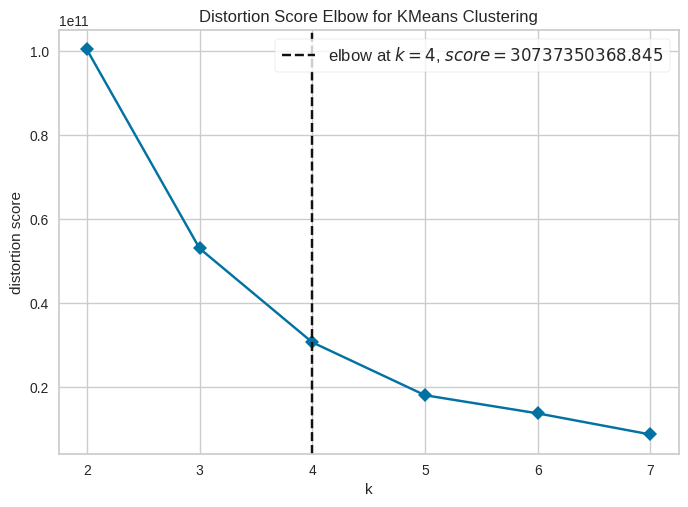

In [25]:

# Cria o modelo base
model = KMeans()

# Cria o visualizador do cotovelo
kmeans = KElbowVisualizer(model, k=clusters, timings=False)

# Ajusta aos dados
kmeans.fit(X)

# Exibe o gráfico
kmeans.show();


### 7.2. Silhouette Score ( SS )

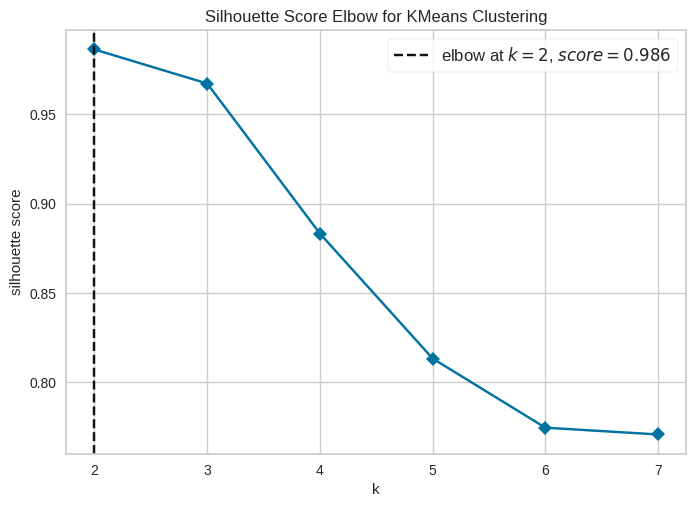

In [26]:
# Cria o modelo com o número de clusters ideal
kmeans = KElbowVisualizer( model, k=clusters,  metric='silhouette', timings=False)

# Ajusta aos dados
kmeans.fit(X)

# Exibe o gráfico
kmeans.show();

### 7.3. Silhouette Analysis

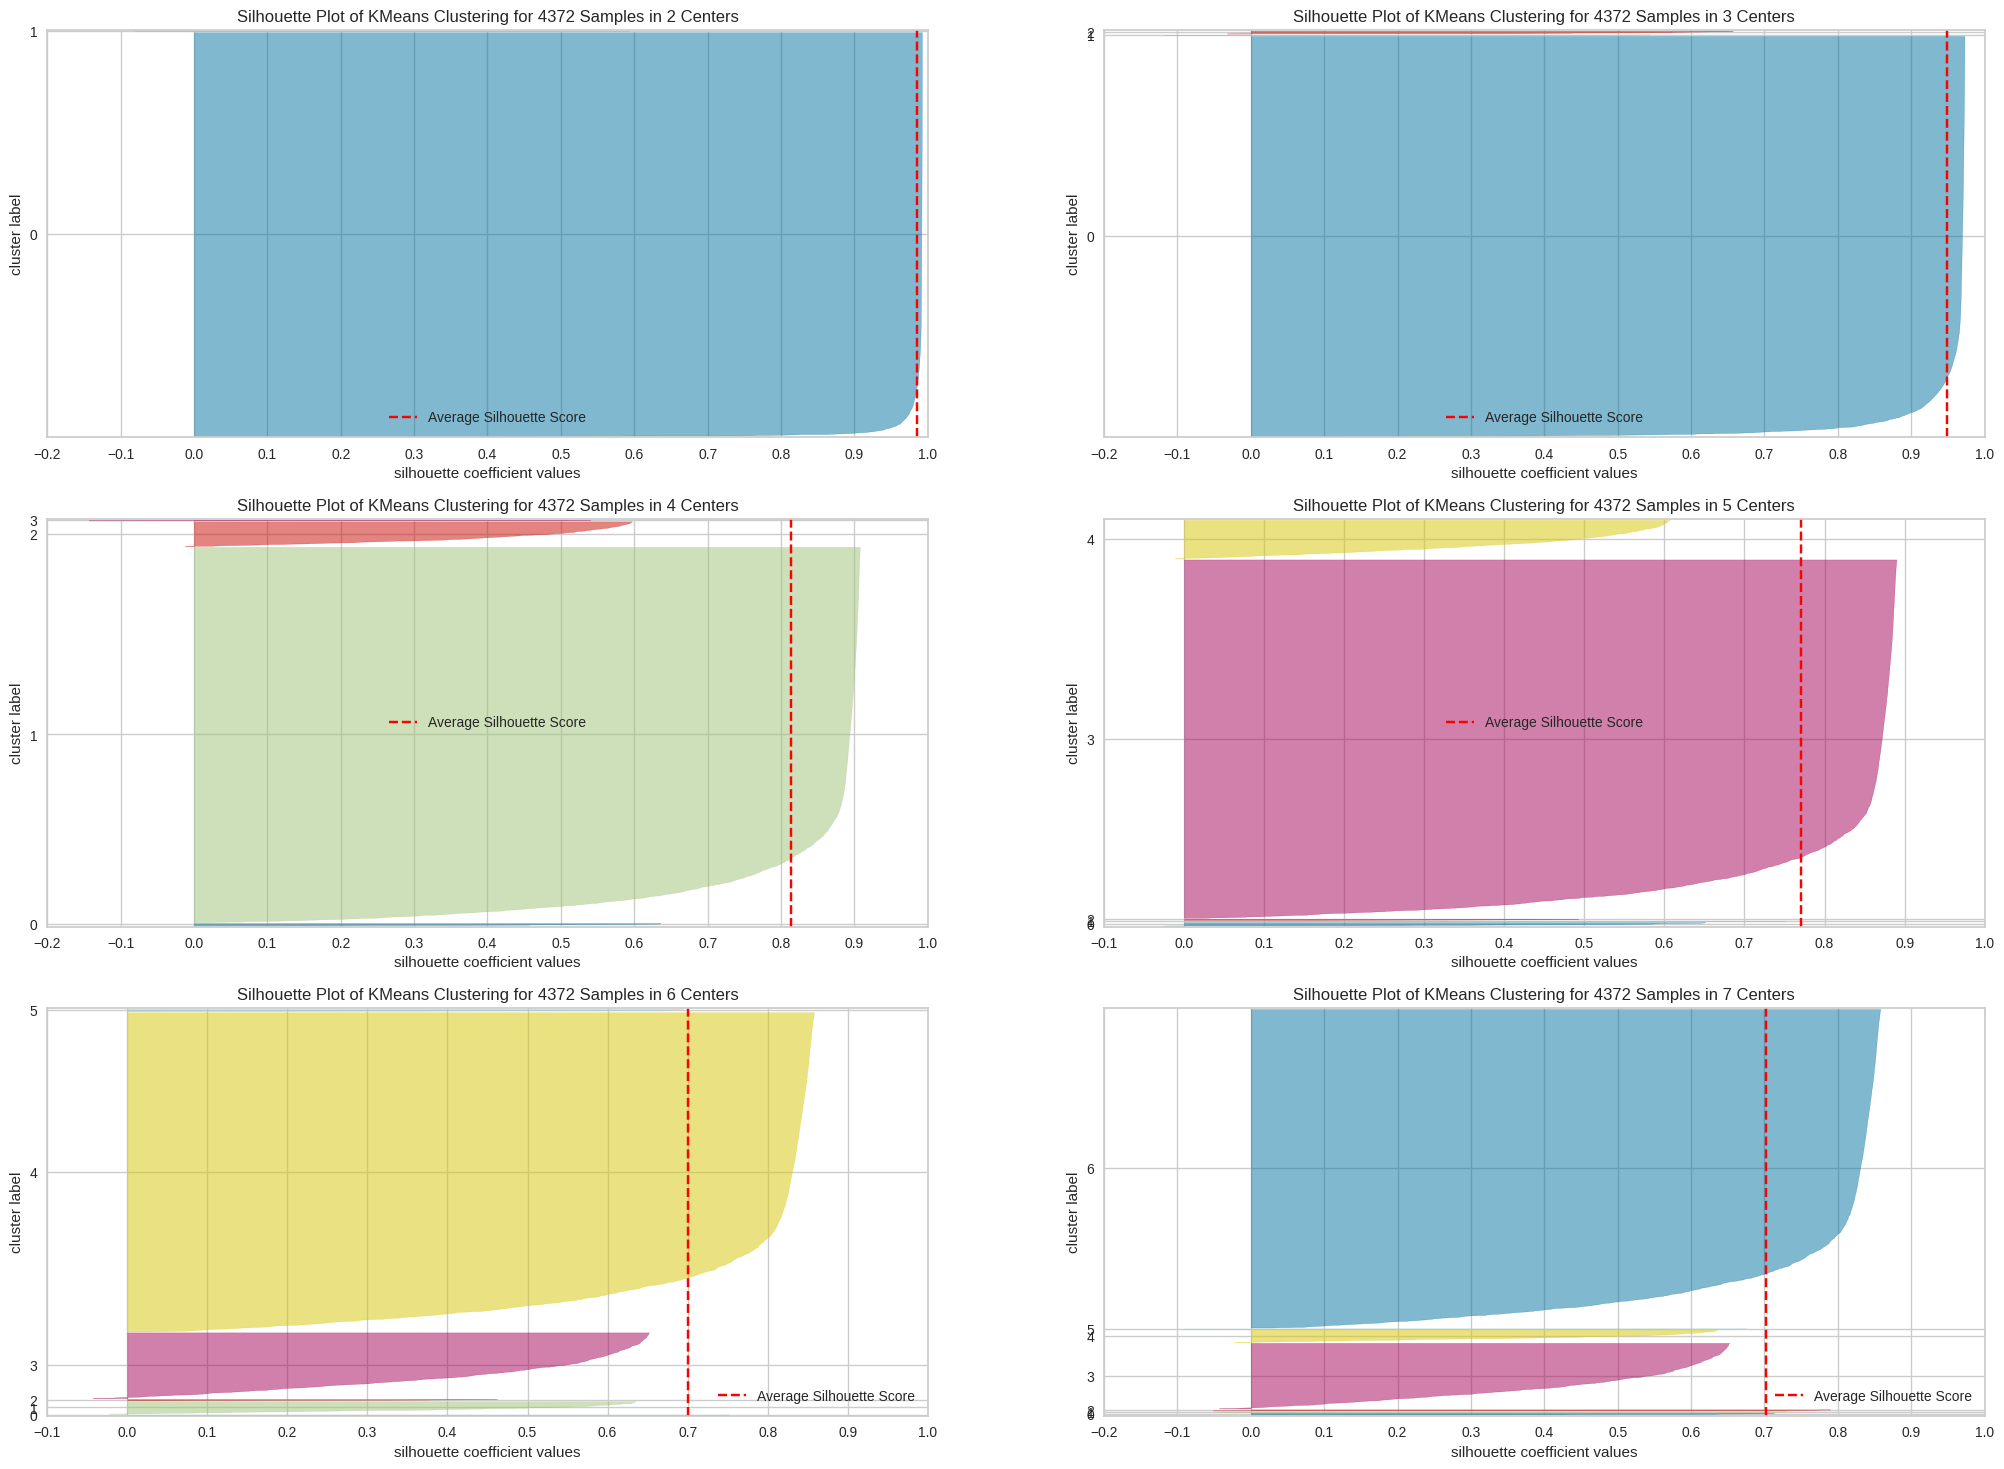

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

k = 2

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )

    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize();

# <font color='red'>8.0. Model Training</font> 

### 8.1. K-Means

In [28]:
# model definition
k = 4
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# cluster labels
labels = kmeans.labels_


### 8.2. Cluster Validation

In [ ]:
# WSS
print(f'WSS value: {kmeans.inertia_:.2f}')
# SS
print(f'SS value: {m .silhouette_score( X, labels, metric="euclidean" ) :.3f}')

WSS value: 40225025312.34


NameError: name 'silhouette_score' is not defined

# <font color='red'>9.0. Cluster Analysis</font> 

In [32]:
df9 = df6.copy()
df9['cluster'] = labels
# Visualize the clusters
df9.head()

,customer_id,gros_revenue,recence_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,312,16.950737,2
1,13047,3079.10,31,196,15.709694,1
2,12583,7187.34,2,251,28.634821,2
3,13748,948.25,95,28,33.866071,1
4,15100,635.10,330,6,105.850000,1


### 9.1. Visualization Inspection 

/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


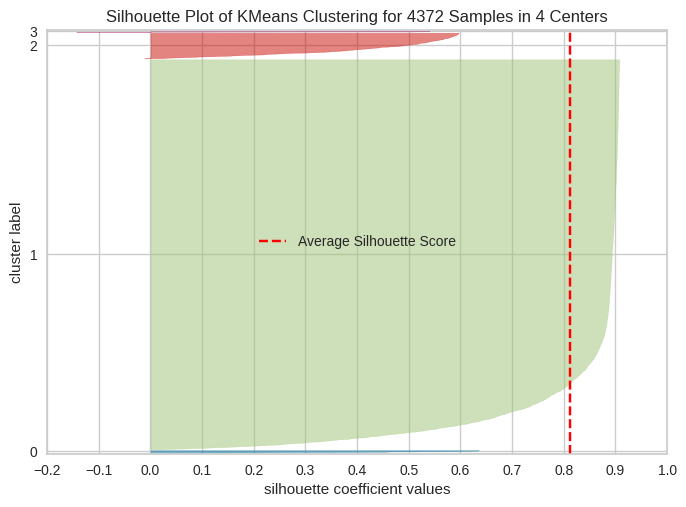

In [33]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

### 9.1. Visualization Inspection para 3 dimensões

In [ ]:
# import nbformat
# fig = px.scatter_3d(df9, x='gros_revenue', y='recence_days', z='invoice_no', color='cluster')

# fig.show()

### 9.2. 2d Plot

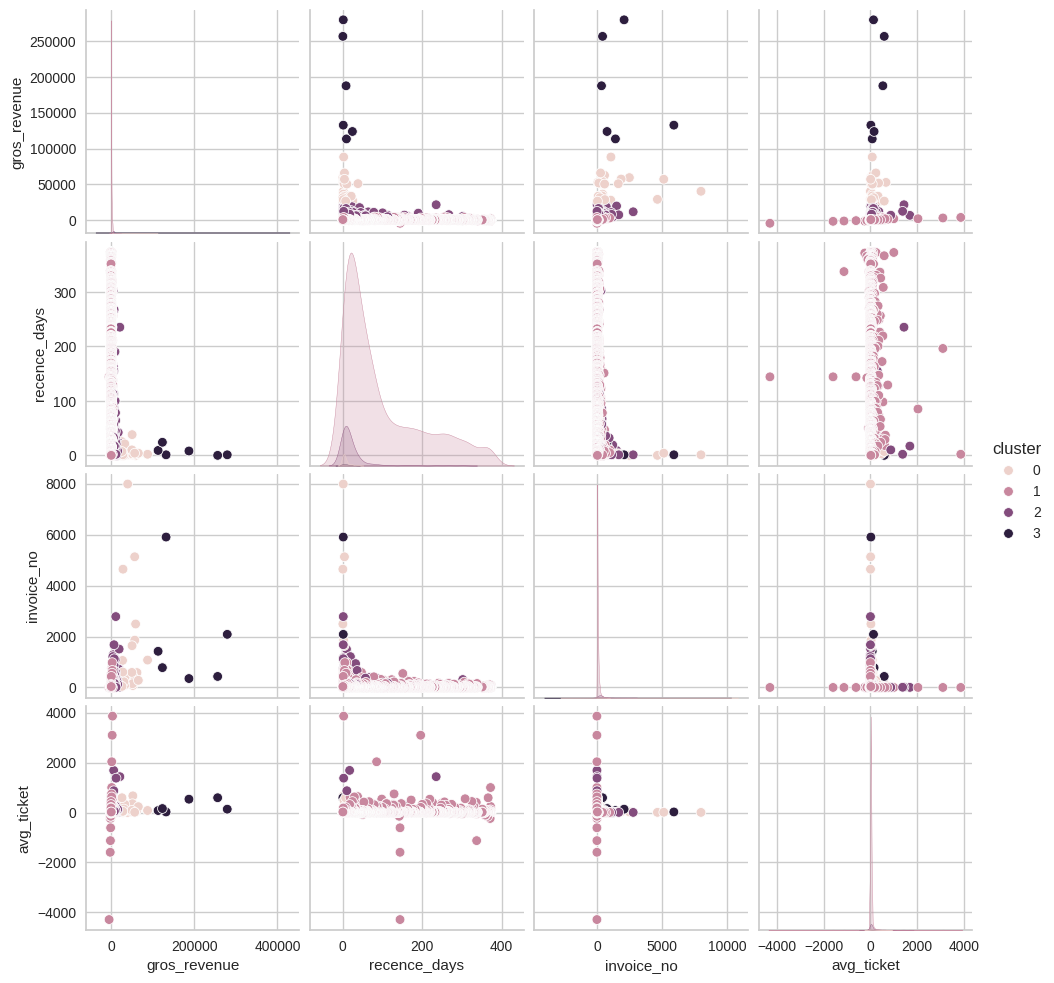

In [34]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='cluster');

### 9.3. UMAP

/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/las/Documentos/repos/ds_clusterizacao/env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: xlabel='component_1', ylabel='component_2'>

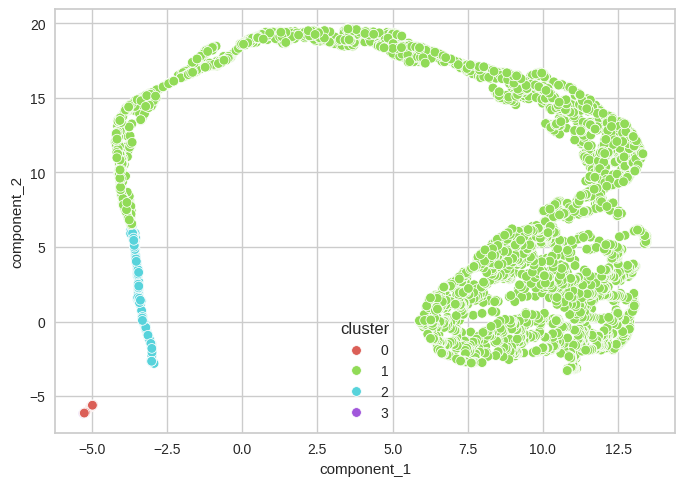

In [35]:

reducer = umap.UMAP( n_neighbors= 20
                    , random_state=42)
embedding = reducer.fit_transform( X)

# embedding
df_viz['component_1'] = embedding[:, 0]
df_viz['component_2'] = embedding[:, 1]

# plot
sns.scatterplot( 
                x='component_1',
                y='component_2',
                hue='cluster',
                palette=sns.color_palette( 'hls', n_colors= len( df_viz['cluster'].unique() ) ),
                data=df_viz
            )


In [36]:
df9.head()

,customer_id,gros_revenue,recence_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,312,16.950737,2
1,13047,3079.10,31,196,15.709694,1
2,12583,7187.34,2,251,28.634821,2
3,13748,948.25,95,28,33.866071,1
4,15100,635.10,330,6,105.850000,1


In [37]:
# Number od customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['%_customers'] = round( (df_cluster['customer_id'] / df_cluster['customer_id'].sum() ) * 100, 2 )

# Media de gros_revenue
df_avg_gros_revenue = round( df9[['gros_revenue', 'cluster']].groupby('cluster').mean().reset_index(), 2 )
df_cluster = df_cluster.merge(df_avg_gros_revenue, on='cluster', how='inner')

# Media de recence_days
df_avg_recence_days = round( df9[['recence_days', 'cluster']].groupby('cluster').mean().reset_index(), 2 )
df_cluster = df_cluster.merge(df_avg_recence_days, on='cluster', how='inner')

# Media de invoice_no
df_avg_invoice_no = round( df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index(), 0)
df_cluster = df_cluster.merge(df_avg_invoice_no, on='cluster', how='inner')
df_cluster.columns = ['cluster', 'n_customers', '%_customers', 'avg_gros_revenue', 'avg_recence_days', 'avg_invoice_no']
df_cluster = df_cluster.sort_values(by='cluster').reset_index(drop=True)

df_ticket = round( df9[['cluster','avg_ticket']].groupby('cluster').mean().reset_index(), 2)
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster', how='left')
df_cluster

,cluster,n_customers,%_customers,avg_gros_revenue,avg_recence_days,avg_invoice_no,avg_ticket
0,0,28,0.64,42614.39,6.18,1131.0,162.86
1,1,4071,93.12,946.70,96.97,67.0,25.36
2,2,267,6.11,8089.03,20.28,340.0,62.78
3,3,6,0.14,182181.98,7.17,1828.0,253.63


# <font color='red'>10.0. Deploy To Production</font> 